In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
# from backtest import executer
import matplotlib.pyplot as plt
import plotly.express as px
import math
import ast
from scipy.stats import spearmanr, kstest


In [2]:
sns.set(rc={'figure.figsize':(15,8)})

In [3]:
portfolio = pd.read_excel('PORTFOLIO.xlsx')

df = pd.read_csv('comVar.csv')

df['date'] = pd.to_datetime(df.date)
df['open_date'] = pd.to_datetime(df.open_date)
df['days_open'] = df['days_open'].astype(float)
df['stock1'] = [pair.split("'")[1] for pair in df.pair]

In [4]:
df = df.merge(portfolio.drop_duplicates('ticker'), left_on='stock1', right_on='ticker',how='left')

df.drop(columns=['stock1', 'ticker'], inplace=True)
df['pair'] = df.pair.apply(ast.literal_eval)
df['sorted_pair'] = df.pair.apply(sorted).apply(tuple)

In [5]:
df.drop_duplicates(subset=['date', 'sorted_pair'], keep='first',inplace=True)

In [6]:
df.loc[df['residual_open'] < df['std_open_residual'], 'side'] = 'lower'
df.loc[df['residual_open'] > df['std_open_residual'], 'side'] = 'upper'

In [7]:
returns_list = []
i=1
closed = df.loc[df.status=='close']

for row in closed.itertuples():

    historico_par = df.loc[(df.pair==row.pair) & (df.date.between(row.open_date,row.date))].copy()
    historico_par.set_index('date', inplace=True)
    historico_par['id'] = i
    
    
#     display(historico_par)
#     Custo entrada: 1,22% + 0,1% = 1,31%
#     Custo saida: 1,22% + 0,25% + 0,1% = 1,57% + Aluguel
    
#     display(historico_par)
    aluguel = (1.0143)**((row.days_open+2)/252) -1
    try:
        if row.side == 'lower':
            
            historico_par['ratio_sem_custos'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
            
            # Entrada
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1-0.0071)
            
                    
            # Saída
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_fst_stock'] / historico_par['price_scnd_stock']
            
        else:
            
            historico_par['ratio_sem_custos'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
            
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock']
            # Entrada
            historico_par.at[row.open_date, 'price_scnd_stock'] = historico_par.loc[row.open_date, 'price_scnd_stock'] * (1+0.0071)
            historico_par.at[row.open_date, 'price_fst_stock'] = historico_par.loc[row.open_date, 'price_fst_stock'] * (1-0.0071)

            # Saida
            historico_par.at[row.date, 'price_scnd_stock'] = historico_par.loc[row.date, 'price_scnd_stock'] * (1-0.0071)
            historico_par.at[row.date, 'price_fst_stock'] = historico_par.loc[row.date, 'price_fst_stock'] * (1+(0.0071+aluguel))

            historico_par['ratio'] = historico_par['price_scnd_stock'] / historico_par['price_fst_stock']
        
        
        historico_par['open_price_first_stock'] = historico_par.at[row.open_date, 'price_fst_stock']
        historico_par['open_price_scnd_stock'] = historico_par.at[row.open_date, 'price_scnd_stock']
        
        historico_par['return'] = (historico_par.ratio / historico_par.ratio.shift(1)) -1
        historico_par['retorno_acumulado'] = np.cumprod(1+historico_par['return']) -1
        
        historico_par['return_sem_custos'] = (historico_par.ratio_sem_custos / historico_par.ratio_sem_custos.shift(1)) -1
        historico_par['retorno_acumulado_sem_custos'] = (np.cumprod(1+historico_par['return_sem_custos']) -1)
        
        returns_list.append(historico_par)
        
    except Exception as e:
#         print(e)
        pass
    
    i+=1

In [8]:
def result_calculator(row, kind='CN'):
    
    if kind=='CN':
        multiplier = 1
    if kind == 'BN':
        multiplier = row.beta_open
    
    if row['residual_open'] < row['std_open_residual']:
        long_result =(row['price_fst_stock'] / row['open_price_first_stock'])
        short_result = (row['open_price_scnd_stock'] / row['price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1
        
        return result, 'lower'
    
    elif row['residual_open'] > row['std_open_residual']:
        long_result = (row['open_price_first_stock'] / row['price_fst_stock'])
        short_result = (row['price_scnd_stock'] / row['open_price_scnd_stock'])
        
        short_result = multiplier * short_result
        result = (long_result * short_result) - 1

        return result, 'upper'

In [9]:
df_returns = pd.concat(returns_list)
df_returns.reset_index(inplace=True)

In [10]:
log_retorno = np.log(1+df_returns.set_index(['date', 'pair', 'open_date','status'])[['return', 'return_sem_custos']]).fillna(0)
retorno_acumulado =  np.exp(log_retorno.cumsum()) - 1
retorno_acumulado.reset_index(inplace=True)

In [11]:
df_returns.halflife.mean()

7.42054433713784

In [12]:
closed = df_returns.loc[df_returns.status=='close']

In [13]:
ibov = pd.read_csv('ibov.csv', usecols=[0,4], index_col=0)
ibov.index = pd.to_datetime(ibov.index)
ibov = ibov.loc[df_returns.date.min():df_returns.date.max()]

In [14]:
log_ret_ibov = np.log(ibov/ibov.shift())
ibov_return = ibov/ibov.shift() -1
ibov_retornos = ibov/ibov.shift() -1
cumsum_ibov = np.cumsum(log_ret_ibov)
ibov_pct = np.exp(cumsum_ibov) -1

In [15]:
# Retorno com custos
acumulado_com_custos = np.cumprod(1+df_returns.groupby('date').sum()['return']) -1

In [16]:
# Resultado sem custos por dia
acumulado_sem_custo = np.cumprod(1+df_returns.groupby('date').sum().return_sem_custos) -1


In [17]:
# Operações Fechadas
fechadas = df_returns.loc[df_returns.status=='close']

fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0

retorno_diario = df_returns.groupby('date').sum()

<ipython-input-17-902cf3657bf9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_bruto'] = fechadas['retorno_acumulado_sem_custos'] > 0
<ipython-input-17-902cf3657bf9>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fechadas['e_lucro_liquido'] = fechadas['retorno_acumulado'] > 0


# Graficos

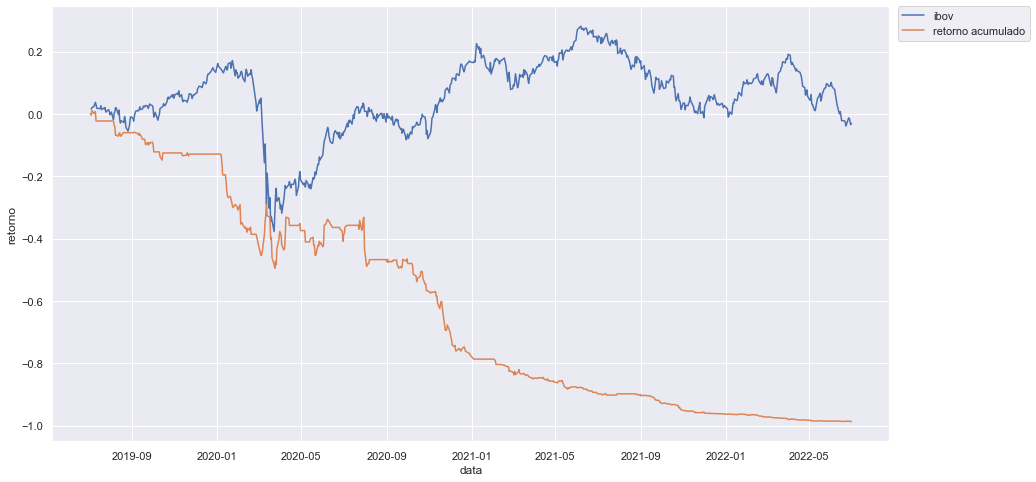

In [18]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_com_custos.index, y=acumulado_com_custos, label='retorno acumulado')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# sns.lineplot(x=cumsum_result_BN.index, y=cumsum_result_BN, label='cointegration beta neutral')


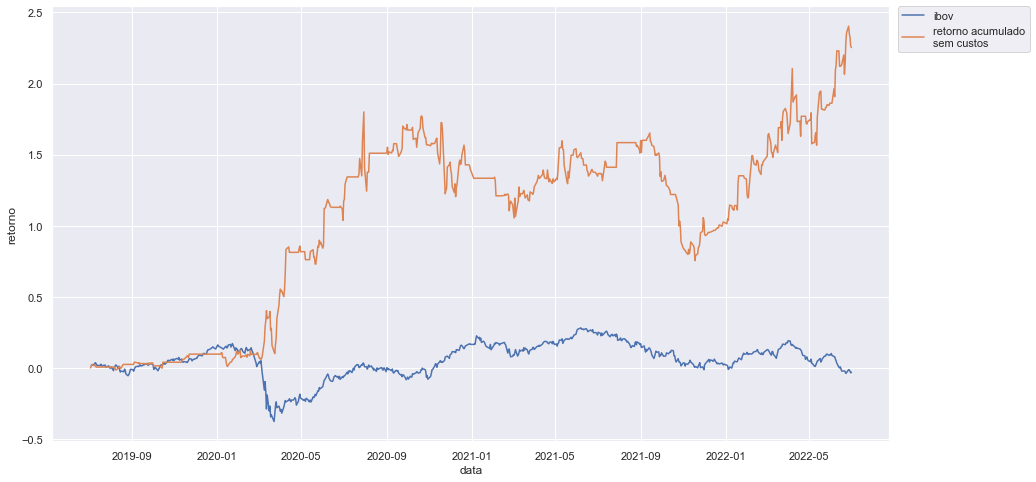

In [19]:
sns.lineplot(x=ibov_pct.index, y=ibov_pct.close, label='ibov')
sns.lineplot(x=acumulado_sem_custo.index, y=acumulado_sem_custo, label='retorno acumulado\nsem custos')
plt.ylabel('retorno')
plt.xlabel('data')

plt.legend()
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

In [20]:
retornos_diarios = pd.concat([ibov_return, retorno_diario[['return', 'return_sem_custos']]], axis=1)
retornos_diarios.fillna(0, inplace=True)
retornos_diarios.columns = ['ibov', 'retorno_com_custos', 'retorno_sem_custos']

In [21]:
log_retornos = np.log(1+retornos_diarios)
retornos_acumulados = np.exp(log_retornos.cumsum()) -1
retornos_acumulados

,ibov,retorno_com_custos,retorno_sem_custos
2019-07-03,0.000000,0.000000,0.000000
2019-07-04,0.015611,-0.003661,0.010588
2019-07-05,0.020060,0.010990,0.025449
2019-07-08,0.024372,0.001046,0.015362
2019-07-10,0.036984,0.007896,0.022310
...,...,...,...
2022-06-27,-0.012534,-0.985626,2.403570
2022-06-28,-0.014229,-0.986053,2.350427
2022-06-29,-0.023725,-0.986158,2.325216
2022-06-30,-0.034309,-0.986614,2.264225


# Descritivas

In [22]:
retornos_diarios.describe()

,ibov,retorno_com_custos,retorno_sem_custos
count,745.000000,745.000000,745.000000
mean,0.000142,-0.005483,0.001872
std,0.019005,0.024799,0.024063
min,-0.147797,-0.154388,-0.140516
25%,-0.008153,-0.012048,-0.003544
50%,0.000625,0.000000,0.000000
75%,0.009616,0.000000,0.006023
max,0.139082,0.109968,0.140733


In [23]:
coeficiente_liquido, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_com_custos']])
print('Correlação de Spearman Resutado líquido: {:0.3}'.format(coeficiente_liquido))

Correlação de Spearman Resutado líquido: 0.0442


In [24]:
coeficiente_bruto, p_valor = spearmanr(retornos_diarios[['ibov', 'retorno_sem_custos']])
print('Correlação de Spearman Resutado bruto: {:0.3}'.format(coeficiente_bruto))

Correlação de Spearman Resutado bruto: 0.071


In [25]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_sem_custos, 'norm')

KstestResult(statistic=0.46452497829579165, pvalue=9.203229662673582e-148)

In [26]:
# TESTE NORMALIDADE
#perform Kolmogorov-Smirnov test
kstest(retornos_diarios.retorno_com_custos, 'norm')

KstestResult(statistic=0.4666931040907797, pvalue=3.1901618459622263e-149)

In [27]:
df_returns['return'].describe()

count    948.000000
mean      -0.004309
std        0.021086
min       -0.109944
25%       -0.013428
50%       -0.003831
75%        0.005508
max        0.110137
Name: return, dtype: float64

In [28]:
df_returns['return_sem_custos'].describe()

count    948.000000
mean       0.001471
std        0.020706
min       -0.109944
25%       -0.008107
50%        0.000754
75%        0.009533
max        0.119451
Name: return_sem_custos, dtype: float64

# Eficacia

In [29]:
eficacia = fechadas.set_index('open_date').resample('6M').agg(
    num_operacoes = ('pair', 'count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    tempo_medio_operacao = ('days_open', 'mean')
)

eficacia

,num_operacoes,taxa_acerto,tempo_medio_operacao
open_date,,,
2019-07-31,1,1.000000,5.000000
2020-01-31,16,0.750000,4.687500
2020-07-31,36,0.611111,4.055556
2021-01-31,30,0.566667,5.933333
2021-07-31,29,0.620690,6.413793
2022-01-31,34,0.558824,4.705882
2022-07-31,45,0.600000,4.511111


# Desempenho

In [30]:
vol_ibov = log_ret_ibov.close.std() * math.sqrt(252)
vol_ibov

0.3060079618164384

In [31]:
log_return = np.log(1+retorno_diario['return'])
vol_return = log_return.std() * math.sqrt(252)
vol_return

0.4637053998290451

In [32]:
log_return_sem_custo = np.log(1+retorno_diario['return_sem_custos'])
vol_return_sem_custo = log_return_sem_custo.std() * math.sqrt(252)
vol_return_sem_custo

0.44422948792577593

In [33]:
retorno_acumulado_bruto = retorno_acumulado['return_sem_custos'].iloc[-1]
taxa_acerto = fechadas['e_lucro_bruto'].mean()
retorno_acumulado_liquido = retorno_acumulado['return'].iloc[-1]

desempenho = pd.DataFrame([{
    'retorno_acumulado_bruto':retorno_acumulado_bruto,
    'taxa_acerto': taxa_acerto,
    'retorno_acumulado_liquido': retorno_acumulado_liquido,
    'desvio_padrao': vol_return,
    'sharpe': retorno_acumulado_liquido/vol_return,
    'correlacao_ibov': coeficiente_liquido
    }])

desempenho

,retorno_acumulado_bruto,taxa_acerto,retorno_acumulado_liquido,desvio_padrao,sharpe,correlacao_ibov
0,2.295898,0.60733,-0.986519,0.463705,-2.12747,0.044208


In [34]:
fechadas_halflife = fechadas.loc[(fechadas.days_open > fechadas.halflife) & (fechadas.beta_close!='VAR CLOSE')]
fechadas_stop_var = fechadas.loc[(fechadas.beta_close=='VAR CLOSE')]
fechadas_retorno = fechadas.loc[(abs(fechadas.last_residual) <= fechadas.close_limit) & (fechadas.beta_close!='VAR CLOSE') & (fechadas.days_open <= fechadas.halflife)]

In [35]:
todos_indices = fechadas_stop_var.index.tolist() + fechadas_halflife.index.tolist() + fechadas_retorno.index.tolist()

seen = set()
dupes = [x for x in todos_indices if x in seen or seen.add(x)]    

In [36]:
set(fechadas.index.tolist()) - set(todos_indices)

{1111}

In [37]:
fechadas.groupby('setor').agg('sum')

,price_fst_stock,price_scnd_stock,beta_open,last_residual,std_residual,std_open_residual,residual_open,open_price_first_stock,open_price_scnd_stock,close_limit,...,var_limit,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
setor,,,,,,,,,,,,,,,,,,,,,
Aéreas,18.487798,26.195276,0.707735,-5.231722,1.947561,1.854899,-4.749677,20.252781,27.691981,0.927450,...,-0.037880,287,1.433808,1.412991,-0.088424,-0.067872,-0.046637,-0.011363,1,0
Bens Industriais,66.210730,67.838674,4.551102,-3.723671,3.830199,3.689907,-4.515384,66.527746,67.019877,1.844953,...,-0.122537,596,4.373670,4.310383,-0.026821,-0.114136,0.061651,0.028827,3,2
Construção Civil,59.670920,69.026408,2.712613,4.405035,2.115526,2.083812,4.739335,59.544213,70.919982,1.041906,...,-0.065450,602,4.693497,4.625766,-0.012415,-0.109608,0.060477,0.003797,2,0
Educação,7.556020,53.477594,0.477652,1.427343,0.595077,0.569337,1.600311,7.734691,55.571778,0.284668,...,-0.083798,462,21.701266,21.387874,0.122129,-0.031423,0.183562,0.055153,1,1
Exploração de imóveis,112.162528,128.433669,6.366261,-3.536638,3.381324,3.327263,0.859287,116.451151,126.771927,1.663631,...,-0.101596,266,6.218954,6.129054,-0.127767,0.104311,0.001872,0.311958,6,4
Financeiro,769.174685,936.851329,59.235988,-22.676334,36.305994,35.490756,-25.233716,765.945145,938.253495,17.745378,...,-0.815070,3628,62.127160,61.227642,-0.403486,-1.077591,0.351879,0.176710,27,6
Mineração e Siderurgia,676.266922,439.477989,42.679435,0.000831,21.138797,20.132387,12.514787,671.906333,432.731194,10.066194,...,-0.505252,2306,31.612454,31.153578,-0.394899,-0.864923,0.024948,-0.159174,13,3
Papel e Celulose,136.538859,328.734461,1.578734,-4.921762,3.907848,3.915541,-5.872342,137.691015,327.739923,1.957771,...,-0.098014,947,4.416231,4.352475,-0.084502,-0.082836,0.002174,0.089737,4,2
"Petroleo, gás e biocombustíveis",462.659331,447.613107,21.509183,23.147184,13.307596,12.431384,14.186558,460.973190,451.767663,6.215692,...,-0.319217,2327,20.701742,20.402191,-0.256632,-0.725523,0.090737,-0.162845,12,1


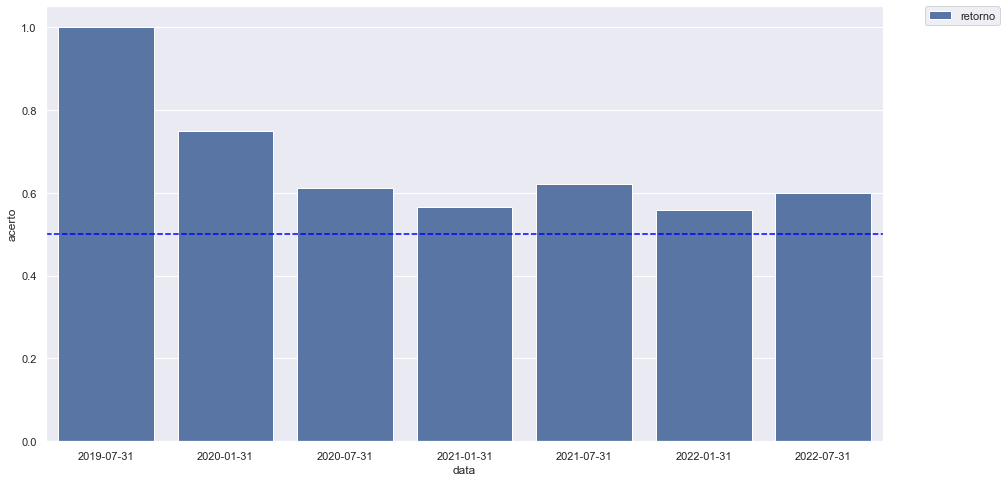

In [38]:
halfyear_accuracy = fechadas.set_index('open_date').resample('6M')[['e_lucro_bruto']].mean().reset_index()
halfyear_accuracy.columns = ['open_date', 'retorno']
halfyear_accuracy['open_date'] = halfyear_accuracy['open_date'].dt.date
halfyear_accuracy = halfyear_accuracy.melt(id_vars='open_date', value_name='acerto')

sns.barplot(x='open_date', y='acerto', hue='variable', data=halfyear_accuracy)
plt.axhline(y=0.5, color='blue', linestyle='--')
plt.xlabel('data')
# plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [39]:
halfyear_accuracy

,open_date,variable,acerto
0,2019-07-31,retorno,1.000000
1,2020-01-31,retorno,0.750000
2,2020-07-31,retorno,0.611111
3,2021-01-31,retorno,0.566667
4,2021-07-31,retorno,0.620690
5,2022-01-31,retorno,0.558824
6,2022-07-31,retorno,0.600000


In [40]:
fechadas

,date,pair,status,price_fst_stock,price_scnd_stock,beta_open,beta_close,last_residual,std_residual,std_open_residual,...,side,id,ratio_sem_custos,ratio,return,retorno_acumulado,return_sem_custos,retorno_acumulado_sem_custos,e_lucro_bruto,e_lucro_liquido
5,2019-07-11,"(BRML3, MULT3)",close,13.980032,27.625499,0.574055,VAR CLOSE,-0.636825,0.337338,0.330478,...,lower,1,0.513494,0.506055,-0.030234,-0.022577,-0.015980,0.005974,True,False
12,2019-08-19,"(BRML3, MULT3)",close,14.075485,25.358666,0.559065,VAR CLOSE,0.337346,0.359815,0.349590,...,upper,2,1.828203,1.801619,0.011286,0.008848,0.026208,0.038375,True,True
16,2019-08-08,"(ELET3, ELET6)",close,38.451762,35.386956,1.105281,VAR CLOSE,2.213153,0.675603,0.650826,...,upper,4,0.933718,0.920295,-0.028446,-0.046767,-0.014275,-0.019032,False,False
26,2019-09-16,"(ELET6, ELET3)",close,38.958454,38.365656,0.869179,0.866586225082961,0.908512,0.612395,0.621898,...,upper,5,0.999483,0.984784,-0.014444,-0.022675,0.000266,0.006098,True,False
36,2019-10-02,"(ELET6, ELET3)",close,34.393483,32.835203,0.866590,VAR CLOSE,1.142085,0.623909,0.618223,...,upper,6,0.968942,0.954693,-0.026550,-0.043948,-0.012020,-0.015801,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,2022-06-09,"(LREN3, VIIA3)",close,25.256474,2.889339,1.333153,1.3051668765911315,0.606552,1.530042,1.570381,...,upper,195,0.116075,0.114400,-0.004607,0.009677,0.009968,0.039112,True,True
1125,2022-05-19,"(PETZ3, ALPA4)",close,12.659475,20.898943,0.286549,VAR CLOSE,-2.128658,1.601278,1.575374,...,lower,196,0.614754,0.605747,-0.056926,0.060687,-0.042903,0.091853,True,True
1131,2022-02-07,"(SOMA3, ALPA4)",close,13.369452,25.775684,0.213015,VAR CLOSE,1.943567,1.283011,1.245217,...,upper,197,1.956292,1.927954,0.024809,-0.059420,0.039872,-0.031945,False,False
1136,2022-04-08,"(VIIA3, LREN3)",close,3.574440,26.767631,0.645305,VAR CLOSE,-1.436871,1.164183,1.150397,...,lower,198,0.135491,0.133536,-0.089497,-0.097280,-0.076165,-0.070963,False,False


In [41]:
display(fechadas.groupby(['setor', 'open_date']).e_lucro_bruto.mean().reset_index())

,setor,open_date,e_lucro_bruto
0,Aéreas,2022-06-13,0.0
1,Aéreas,2022-06-15,1.0
2,Bens Industriais,2020-01-07,0.0
3,Bens Industriais,2021-12-29,1.0
4,Bens Industriais,2022-02-03,1.0
...,...,...,...
178,Varejo,2022-01-31,0.0
179,Varejo,2022-04-04,0.0
180,Varejo,2022-05-09,1.0
181,Varejo,2022-06-02,1.0


Text(0, 0.5, 'acerto')

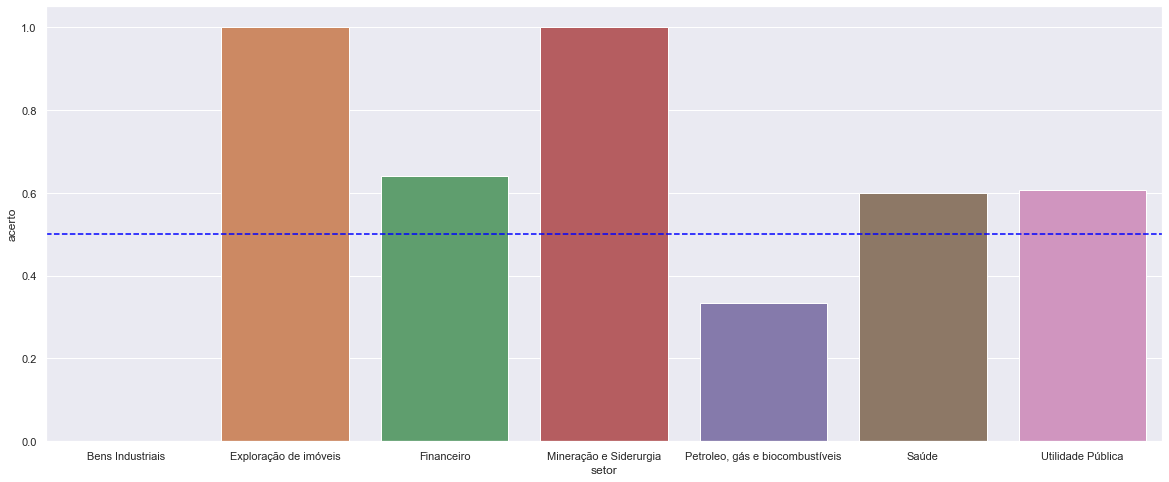

In [42]:
fechadas_agrupadas_semestre = fechadas.groupby(['setor', pd.Grouper(key='open_date', freq='1Y')]).e_lucro_bruto.mean().reset_index()

plt.figure(figsize=(20,8))

fechadas_agrupadas_semestre['open_date'] = pd.to_datetime(fechadas_agrupadas_semestre['open_date'])
fechadas_2020 = fechadas_agrupadas_semestre.set_index('open_date').loc['2020'].reset_index()
fechadas_2020['open_date'] = fechadas_2020.open_date.dt.date

sns.barplot(x='setor', y='e_lucro_bruto', data=fechadas_2020)
plt.axhline(y=0.5, color='blue', linestyle='--')

plt.ylabel('acerto')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [ ]:
fechadas.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),

In [46]:
fechadas_var_semestre = fechadas_stop_var.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_var = ('e_lucro_bruto', 'mean'),
)
fechadas_var_semestre['loss_var'] = 1-fechadas_var_semestre['gain_var']

fechadas_var_semestre

,total_trades,gain_var,loss_var
open_date,,,
2019-07-31,1,1.000000,0.000000
2020-01-31,12,0.833333,0.166667
2020-07-31,27,0.555556,0.444444
2021-01-31,13,0.615385,0.384615
2021-07-31,12,0.583333,0.416667
2022-01-31,15,0.533333,0.466667
2022-07-31,28,0.607143,0.392857


In [44]:
halflife_semestre = fechadas_halflife.set_index('open_date').resample('6M').agg(
    total_trades = ('status', 'count'),
    gain_halflife = ('e_lucro_bruto', 'mean'),
)

halflife_semestre['loss_halflife'] = 1-halflife_semestre['gain_halflife']

halflife_semestre

,total_trades,gain_halflife,loss_halflife
open_date,,,
2019-09-30,1,1.000000,0.000000
2020-03-31,6,0.500000,0.500000
2020-09-30,5,0.600000,0.400000
2021-03-31,22,0.590909,0.409091
2021-09-30,11,0.363636,0.636364
2022-03-31,21,0.523810,0.476190
2022-09-30,4,0.750000,0.250000


# Resumo Pares

In [45]:
fechadas_grouped = fechadas.groupby('sorted_pair').agg(
    trades = ('sorted_pair','count'),
    taxa_acerto = ('e_lucro_bruto', 'mean'),
    prazo_medio_operacao = ('days_open', 'mean'),
    retorno_bruto_acum = ('retorno_acumulado_sem_custos', 'sum'),
    retorno_liquidi_acum = ('retorno_acumulado', 'sum')
)

fechadas_grouped.sort_values(by=['trades', 'taxa_acerto'], ascending=False).head(15)

,trades,taxa_acerto,prazo_medio_operacao,retorno_bruto_acum,retorno_liquidi_acum
sorted_pair,,,,,
"(ELET3, ELET6)",17,0.705882,4.823529,0.128551,-0.357420
"(EQTL3, TAEE11)",16,0.562500,3.687500,0.368348,-0.095134
"(PETR3, PETR4)",13,0.846154,3.615385,0.104016,-0.266910
"(CPFE3, EGIE3)",13,0.615385,5.307692,0.047755,-0.322760
"(GGBR4, GOAU4)",9,0.666667,4.000000,0.020916,-0.234615
"(BBDC3, BBDC4)",7,0.857143,6.285714,0.036114,-0.164076
"(BRML3, MULT3)",7,0.857143,5.285714,0.311958,0.104311
"(FLRY3, QUAL3)",7,0.714286,6.714286,0.253770,0.047152
"(BBDC4, SANB11)",7,0.571429,4.142857,0.072531,-0.127865
